In [1]:
import numpy as np
import pandas as pd
import pickle as pk
import sys

In [2]:
from maiagomes.models import mmar
from maiagomes.testing import Data_handler,testEnv

In [3]:
df = pd.read_csv("../../data/all_quotes.csv")

In [4]:
# symbs = list(set(df.columns) - set(['BTC', 'ETH', 'BNB', 'SOL', 'XRP', 'ADA', 'LUNA']))
symbs = list(set(df.columns) - set(["BNB", "XRP", "ADA", "PBR-A","TWTR"]))

In [5]:
# data = data_handler(df_path = "../data/all_quotes.csv", date_var="Date", filter_out="Date > '2022-01-01'")
data = Data_handler(df = df.loc[:,symbs], date_var="Date", add_cash=True, filter_out="Date > '2023-05-01'")

In [6]:
test = testEnv(data, interval_period = 'D')

In [7]:
from glob import glob
import json

In [8]:
mmar_results = {}
for __file__ in glob("../data/old_model_results/*"):
    date = __file__.split("/")[-1].split("_")[-1].replace(".json","")
    _ = json.load(open(__file__,"rb"))
    mmar_results[date] = {k:v for k,v in _.items() if k in data.symbolList}

In [9]:
def get_expected_return(H = None, mu = None, sigma2 = None, alpha0 = None, N = None, base = 2, expoent = 9, nsamples = 100, use_last_price_only = True, summarize = True, maxloss = 0):
    sampler = mc_mmar(base,expoent, H = H, mu = mu , sigma = np.sqrt(sigma2))
    _df_ = sampler.gen(nsamples, diff = False).query("variable == 'mmar'")
    if use_last_price_only:
        arr = _df_.query(f"t == {sampler.T-1}")['value'].values
    else:
        arr = _df_['value'].values
    if summarize: 
        return ecdf_py(arr)(maxloss)
    else:
        return arr
# get_expected_return(**mmar_results['2023-01-04']['TSLA'], expoent=4, nsamples = 100,maxloss=-2)

In [10]:
from scipy.linalg import inv
from scipy.stats import multinomial, dirichlet
import pandas as pd
from datetime import datetime 
 
def get_random_portfolio(historyPrices,currDate):
    vals = np.isnan(historyPrices[-1,])==False
    N = sum(vals)
    p = vals/N
    return (multinomial.rvs(n=N , p = p)/N).reshape([1,-1])

def get_simple_portfolio(historyPrices,currDate):
    vals = np.isnan(historyPrices[-1,])==False
    N = sum(vals)
    p = vals/N
    return p.reshape([1,-1])


def get_max_portfolio(historyPrices,currDate):
    ans = np.zeros([historyPrices.shape[1]])
    ans[historyPrices[-5:,].mean(axis = 0).argmax()] = 1
    return ans


def get_simple_trend(historyPrices, past_size = 1000):
    if historyPrices.shape[0] <= past_size:
        X = np.log(historyPrices)
    else:
        X = np.log(historyPrices[:-past_size,])
    XX = X[1:,:]-X[:-1,:]
    _XX_ = XX[1:]
    XX = XX[:-1]
    beta = np.zeros(XX.shape[1])
    for i in range(XX.shape[1]):
        XXi = XX[:,i]
        _XX_i = _XX_[:,i]
        try:
            beta[i] = inv(XXi.T.dot(XXi)).dot(XXi.T).dot(_XX_i)
        except:
            pass
    return beta

def get_mmar_portfolio(historyPrices, currDate, mmar_results = mmar_results, min_date = datetime(2021, 11, 2, 0, 0), symbolList = test.data.symbolList):
    latest_results_date = currDate.astype('datetime64[D]')
    results_do_not_exist = str(latest_results_date) not in mmar_results.keys() 
    while results_do_not_exist:
        latest_results_date -= 1
        if datetime.strptime(str(latest_results_date),"%Y-%m-%d") < min_date:
            return get_random_portfolio(historyPrices, currDate)
        else:
            results_do_not_exist = str(latest_results_date) not in mmar_results.keys()
    currEstimates = mmar_results[str(latest_results_date)]
    df = pd.DataFrame(currEstimates).T
    df['norm_mu'] = df['mu']/np.sqrt(df['sigma2']/df['N'])
    p = dirichlet.rvs(df.norm_mu.values)[0]
    df['alloc'] = p 
    allocs = df.alloc.to_dict()
    ans = np.zeros(len(symbolList))
    for i, sym in enumerate(symbolList):
        if sym in allocs.keys():
            ans[i] = allocs[sym]
    ans/=ans.sum()            
    return ans


In [13]:

from itertools import product
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

def auto_tune_arima(
    ts, p_values=range(0, 3), d_values=range(0, 2), q_values=range(0, 3)
):
    split_point = int(len(ts) * 0.9)  # Adjust the split percentage as needed

    # Split the time series into training and testing sets
    train_data = ts[:split_point]
    test_data = ts[split_point:]
    best_mse = float("inf")
    best_order = None

    for p, d, q in product(p_values, d_values, q_values):
        model = sm.tsa.ARIMA(train_data, order=(p, d, q))
        try:
            results = model.fit()
            predicted = results.get_forecast(steps = len(test_data))
            error = predicted.predicted_mean - test_data
            mse = (error**2).sum()
            # aic = results.aic
            if mse < best_mse:
                best_mse = mse
                best_order = (p, d, q)
        except:
            continue
    return best_order


def get_random_portfolio(historyPrices, currDate):
    n_basket = historyPrices.shape[1]
    p = np.array([1.0 / n_basket] * n_basket)
    return (multinomial.rvs(n=n_basket, p=p) / n_basket).reshape([1, -1])


def get_simple_portfolio(historyPrices, currDate):
    n_basket = historyPrices.shape[1]
    return np.array([1.0 / n_basket] * n_basket).reshape([1, -1])
    # vals = np.isnan(historyPrices[-1,]) == False
    # N = sum(vals)
    # p = vals / N
    # return p.reshape([1, -1])



def get_arma_prediction(ts, p=-1, d=0, q=-1, **kwargs):
    if p == -1 or q == -1:
        order = auto_tune_arima(ts, **kwargs)
    else:
        order = (p, d, q)
    model = sm.tsa.ARIMA(ts, order=order)
    results = model.fit()

    forecast_values = results.get_forecast(steps=1)
    return forecast_values


def get_arma_expected_return(ts, stdize = False, **kwargs):
    preds = get_arma_prediction(ts, **kwargs)
    ans = np.log(preds.predicted_mean) - np.log(ts[-1]) 
    if stdize:
        ans += - np.log(preds.se_mean)
    return ans


def get_kelly_c(p, a=1.0, b=1.0):
    _a_ = np.max([a, -1.0 * np.min([0, b])])
    _b_ = np.max([b, -1.0 * np.min([0, a])])
    return p / _a_ - (1 - p) / _b_


def get_arma_win_probability(ts, **kwargs):
    preds = get_arma_prediction(ts, **kwargs)
    diff = preds.predicted_mean - ts[-1]
    p = norm.cdf(diff / preds.se_mean)
    return get_kelly_c(p, b=np.exp(diff)[0])


def adjust_allocation(_expected_returns_,_rho_):
    final_allocation = np.zeros(_expected_returns_.shape)
    argm = _expected_returns_.argmax()
    alloc = _expected_returns_[argm] 
    final_allocation[argm] = alloc
    while alloc > .01 and alloc <= 1:
        _rho_[:,argm] = 1
        _expected_returns_ = ((1-alloc)*_expected_returns_)*(1-_rho_[argm,])
        argm = _expected_returns_.argmax()
        alloc = _expected_returns_[argm] 
        final_allocation[argm] = alloc

    return final_allocation

def get_arma_portfolio(historyPrices, currDate, past_size=10, p=2, d=1, q=-1, **kwargs):
    if historyPrices.shape[0] <= past_size:
        return get_simple_portfolio(historyPrices, currDate)
    expected_returns = np.zeros(historyPrices.shape[1])
    for i in range(historyPrices.shape[1] - 1):
        try:
            expected_returns[i] = get_arma_win_probability(
                np.log(historyPrices[:, i]), p=p, d=d, q=q, **kwargs
            )[0]
        except Exception as e:
            print(f"Problems getting expected returns: {e}")
            continue
    _expected_returns_ = np.nan_to_num(expected_returns, nan=0)
    _expected_returns_ = _expected_returns_ * (_expected_returns_ > 0)
    _rho_ = np.nan_to_num(abs(np.corrcoef(np.diff(np.log(historyPrices),axis = 0).T)))
    _expected_returns_ = adjust_allocation(_expected_returns_,_rho_)
    if _expected_returns_.sum() > 1:
        _expected_returns_ /= _expected_returns_.sum()
    elif _expected_returns_.sum() < 1:
        _expected_returns_[-1] = 1 - _expected_returns_.sum()
    return _expected_returns_.reshape([1, -1])



In [14]:
daily = test.data.get_last_events_by("D").copy()

In [15]:
strategies = {'market' : get_simple_portfolio,'random' : get_random_portfolio,'mmar' : get_mmar_portfolio, 'arma' : get_arma_portfolio}
# strategies = {"market": get_simple_portfolio, "arma": get_arma_portfolio}


In [16]:
rois = test.simulate(strategies = strategies, 
                     reinvest_amount = 0,
                     buy_and_hold = False,
                     showProgress = False)

/Users/guilhermegomes/Documents/maiagomes/maiagomes/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/guilhermegomes/Documents/maiagomes/maiagomes/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/guilhermegomes/Documents/maiagomes/maiagomes/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/guilhermegomes/Documents/maiagomes/maiagomes/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/guilhermegomes/Documents/maiag

<Axes: >

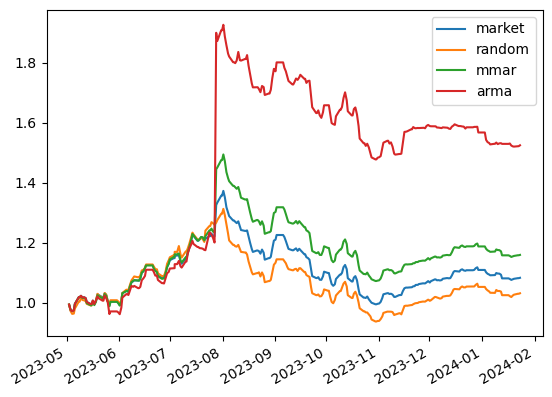

In [39]:
pd.DataFrame(rois[0]).plot()

<Axes: >

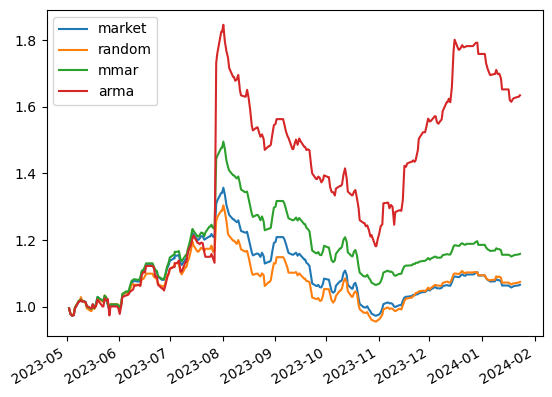

In [35]:
pd.DataFrame(rois[0]).plot()

<Axes: >

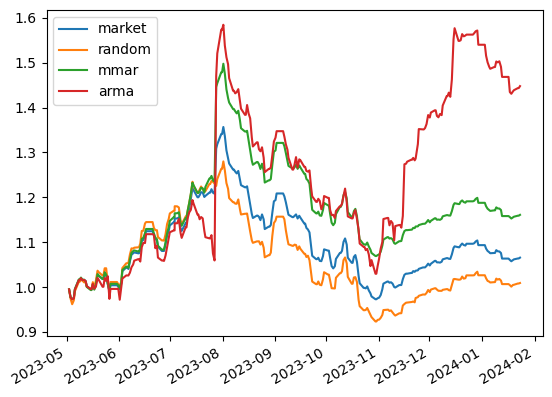

In [46]:
pd.DataFrame(rois[0]).plot()

<Axes: >

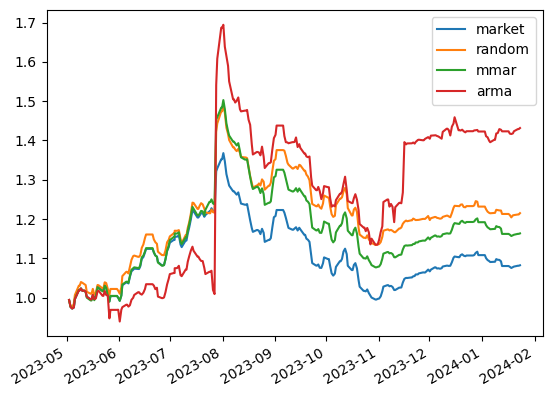

In [ ]:
pd.DataFrame(rois[0]).plot()

In [73]:
rois = test.sample(nSamples = 20,strategies = strategies, reinvest_amount = 0,buy_and_hold = False, showProgress = True)

  0%|          | 0/20 [00:00<?, ?it/s]/Users/guilhermegomes/Documents/maiagomes/maiagomes/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/guilhermegomes/Documents/maiagomes/maiagomes/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/guilhermegomes/Documents/maiagomes/maiagomes/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/93/g3mybg_57p16jzvjbpkk1jlw0000gn/T/ipykernel_35589/1457541647.py:79: DeprecationWarning: Conversion of an 

<Axes: >

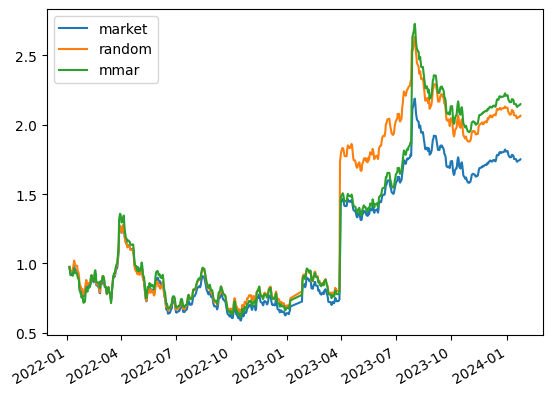

In [79]:
pd.DataFrame(rois[5]['returns']).plot()

In [84]:
df = data.df.set_index("Date")

In [102]:
np.exp(np.log(df).diff().cumsum()).loc['2024-01-24 20:00:00',].sort_values()

SOL       0.019189
AMZN      0.046036
GOOGL     0.050613
SHOP      0.055867
LCID      0.065860
           ...    
NLY       1.917073
X         2.085961
RIG       2.340984
TAL       2.365196
EDU      29.812808
Name: 2024-01-24 20:00:00, Length: 84, dtype: float64

In [80]:
[list(f['returns']['mmar'].values())[-1] for f in rois.values()]

[2.217436549041559,
 2.191238946887033,
 1.9255541969004208,
 2.10593352306581,
 0.0,
 2.1485827990686404,
 2.2467276547303165,
 0.0,
 2.0805228683731496,
 2.172772061826553,
 2.2318575059949364,
 2.0822683333209313,
 2.028212791863197,
 2.155719863933826,
 2.2884661314478865,
 2.271237817997418,
 2.12421385361175,
 2.2814011475425406,
 2.4492445537644523,
 1.8838236999780984]

In [22]:
import seaborn as sns

In [32]:
test.data.symbolList[59]

'LUNA'

In [35]:
test.data.df.LUNA

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
596177    6.91
596178    6.91
596179    6.91
596180    6.91
596181    6.91
Name: LUNA, Length: 596182, dtype: float64

In [29]:
rois[0]['portfolios']['max'][149,].argmax()

59

In [25]:
rois[0]['portfolios']['max'].sum(axis = 1).argmax()

149

<Axes: >

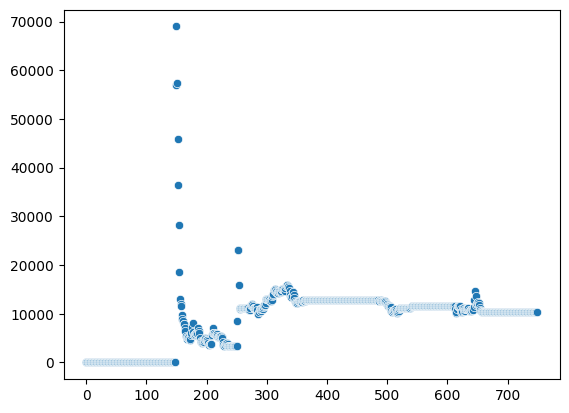

In [23]:
sns.scatterplot(rois[0]['portfolios']['max'].sum(axis = 1))

/Users/guilhermegomes/Documents/maiagomes/maiagomes/.venv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<Axes: >

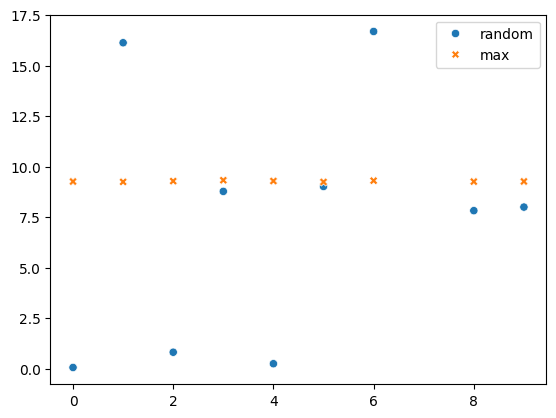

In [78]:
sns.scatterplot(data=np.log(rois))

<Axes: xlabel='random', ylabel='Count'>

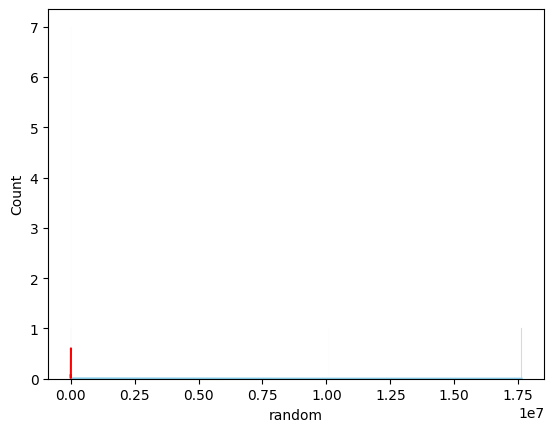

In [75]:
import seaborn as sns
sns.histplot(data=rois, x="random", color="skyblue", label="Sepal Length", kde=True)
sns.histplot(data=rois, x="max", color="red", label="Sepal Width", kde=True)